# Configuration 



Dataset available on kaggle : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [1]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from tqdm.notebook import tqdm 

In [2]:
class CFG:
    
    epochs = 1                                         # No. of epochs of training the model 
    lr = 0.001                                         # Learning rate 
    batch_size = 16                                    # Batch Size For Dataset 
    
    model_name = 'tf_efficientnet_b4_ns'               # Model name (We are going to import model from timm)
    img_size = 224
    
    # Going to be use for loading dataset 
    DATA_DIR = "chest_xray"                       # Data Directory 
    TEST = 'test'                                      # Test folder name in data directory 
    TRAIN = 'train'                                    # Train folder name in data directory 
    VAL ='val'                                         # Valid folder name in data directory 
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
print("On which device we are on : {}".format(device))

On which device we are on : cuda


# Image Transformation and Load Dataset 

In [3]:
from torchvision import transforms as T, datasets
from helper import show_image

In [4]:
train_transform = T.Compose([
    
    T.Resize(size = (CFG.img_size, CFG.img_size)),
    T.RandomRotation(degrees = (-20, +20)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
])

valid_transform = T.Compose([
    
    T.Resize(size = (CFG.img_size, CFG.img_size)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
])

test_transform = T.Compose([
    
    T.Resize(size = (CFG.img_size, CFG.img_size)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
])

In [5]:
train_path = os.path.join(CFG.DATA_DIR, CFG.TRAIN)
valid_path = os.path.join(CFG.DATA_DIR, CFG.VAL)
test_path = os.path.join(CFG.DATA_DIR, CFG.TEST)

trainset = datasets.ImageFolder(train_path, transform = train_transform)
validset = datasets.ImageFolder(valid_path, transform = valid_transform)
testset = datasets.ImageFolder(test_path, transform = test_transform)

In [6]:
print("Trainset Size : {}".format(len(trainset)))
print("Validset Size : {}".format(len(validset)))
print("Testset Size : {}".format(len(testset)))

Trainset Size : 5216
Validset Size : 16
Testset Size : 624


{'NORMAL': 0, 'PNEUMONIA': 1}


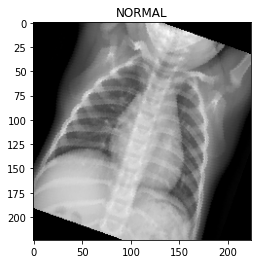

In [7]:
image, label = trainset[2]

print(trainset.class_to_idx)
class_name = ['NORMAL', 'PNEUMONIA']

show_image(image, class_name[label])

# Load Dataset into Batches 

In [8]:
from torch.utils.data import DataLoader 
from torchvision.utils import make_grid
from helper import show_grid

In [9]:
trainloader = DataLoader(trainset, batch_size = CFG.batch_size, shuffle = True)
validloader = DataLoader(validset, batch_size = CFG.batch_size, shuffle = True)
testloader = DataLoader(testset, batch_size = CFG.batch_size, shuffle = True)

In [10]:
print("No. of batches in trainloader : {}".format(len(trainloader)))
print("No. of Total examples : {}".format(len(trainloader.dataset)))

No. of batches in trainloader : 326
No. of Total examples : 5216


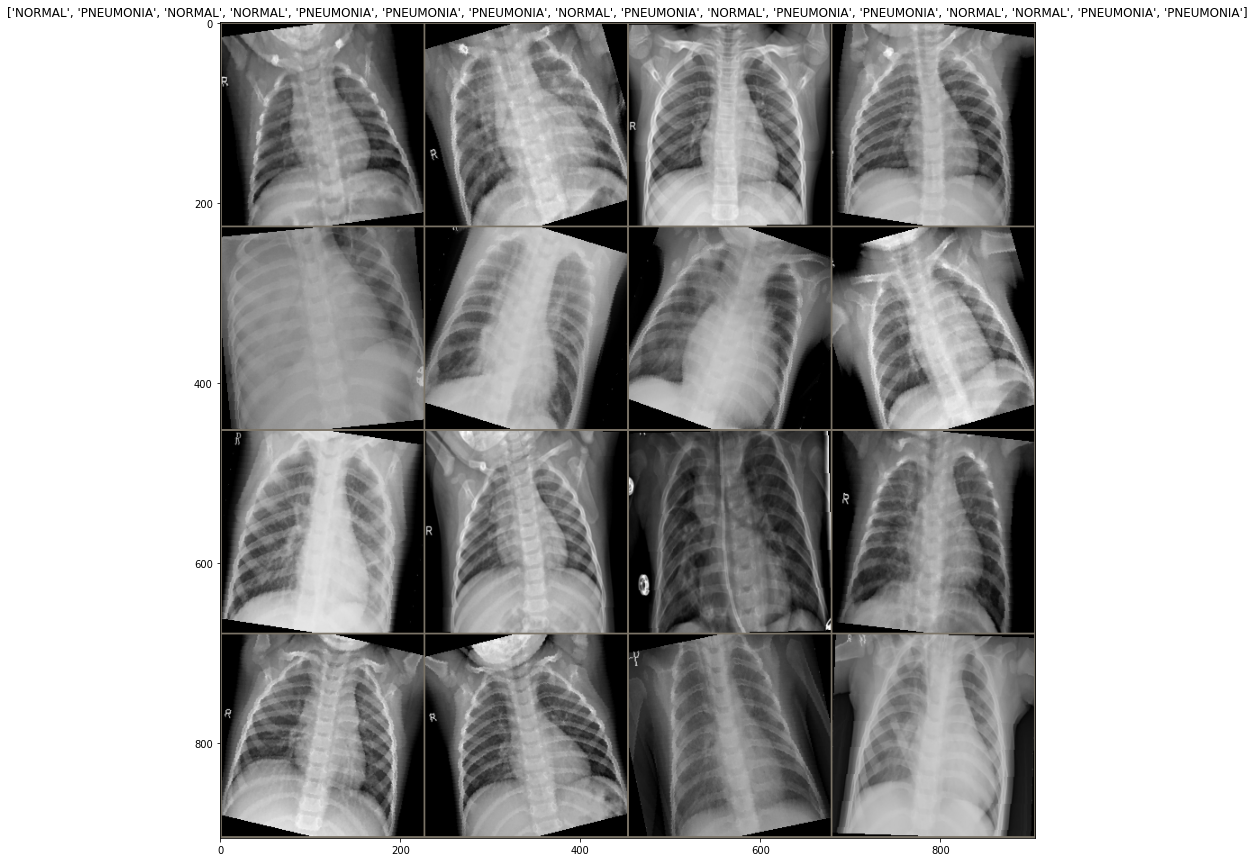

In [11]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

out = make_grid(images, nrow = 4)

show_grid(out, title = [class_name[x] for x in labels])

# Fine Tuning EfficientNet Model 

In [12]:
from torch import nn 
import torch.nn.functional as F
import timm 

model = timm.create_model(CFG.model_name, pretrained=True)


for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(
    
    nn.Linear(in_features = 1792, out_features = 625),
    nn.ReLU(),
    nn.Dropout(p = 0.3),
    nn.Linear(in_features = 625, out_features = 256),
    nn.ReLU(),
    nn.Linear(in_features = 256, out_features = 2)
)

model = model.to(device)

In [13]:
from torchsummary import summary 

summary(model, input_size = (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 112, 112]           1,296
       BatchNorm2d-2         [-1, 48, 112, 112]              96
              SiLU-3         [-1, 48, 112, 112]               0
            Conv2d-4         [-1, 48, 112, 112]             432
       BatchNorm2d-5         [-1, 48, 112, 112]              96
              SiLU-6         [-1, 48, 112, 112]               0
            Conv2d-7             [-1, 12, 1, 1]             588
              SiLU-8             [-1, 12, 1, 1]               0
            Conv2d-9             [-1, 48, 1, 1]             624
          Sigmoid-10             [-1, 48, 1, 1]               0
    SqueezeExcite-11         [-1, 48, 112, 112]               0
           Conv2d-12         [-1, 24, 112, 112]           1,152
      BatchNorm2d-13         [-1, 24, 112, 112]              48
         Identity-14         [-1, 24, 1

# Build a Simple Trainer

In [14]:
from helper import accuracy
from tqdm import tqdm

In [15]:
class PneumoniaTrainer():
    
    def __init__(self, criterion, optimizer, scheduler):
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
    
    def train_batch_loop(self, model, trainloader):
        train_acc = 0
        train_loss = 0
        
        for images, labels in tqdm(trainloader):
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits, labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits, labels)
            
        return train_acc / len(trainloader), train_loss / len(trainloader)

    
    def valid_batch_loop(self, model, validloader):
        valid_acc = 0
        valid_loss = 0
        
        for images, labels in tqdm(validloader):
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits, labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits, labels)
            
        return valid_acc / len(validloader), valid_loss / len(validloader)
            
        
    def fit(self, model, trainloader, validloader, epochs):
        model = model.to(device)
        valid_min_loss = np.inf
        print(torch.cuda.current_device())
        
        for i in range(epochs):
            model.train()
            avg_train_acc, avg_train_loss = self.train_batch_loop(model, trainloader)
            
            model.eval()
            avg_valid_acc, avg_valid_loss = self.valid_batch_loop(model, validloader)
            
            if avg_valid_loss <= valid_min_loss:
                print(f'Valid loss decreased {valid_min_loss} --> {avg_valid_loss}')
                torch.save(model.state_dict(), 'PneumoniaModel.pt')
                valid_min_loss = avg_valid_loss
                
            print(f'Epoch: {i+1}, train_loss: {avg_train_loss}, train_acc: {avg_train_acc}')
            print(f'Epoch: {i+1}, valid_loss: {avg_valid_loss}, valid_acc: {avg_valid_acc}')

In [16]:
print(torch.__version__)

1.11.0+cu113


# Training Model 


Trained on google colab : https://colab.research.google.com/drive/1C5nNPj7OLYMGnNvWBU5W2zSXfgWDdXCo?usp=sharing

In [17]:
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = CFG.lr)
scheduler = None

trainer = PneumoniaTrainer(criterion, optimizer, scheduler)
trainer.fit(model, trainloader, validloader, epochs = CFG.epochs)

0


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

Valid loss decreased inf --> 0.6790713667869568
Epoch: 1, train_loss: 0.2537490895212245, train_acc: 0.8899539709091187
Epoch: 1, valid_loss: 0.6790713667869568, valid_acc: 0.5625


# Plot Results 

In [18]:
from helper import view_classify
trainer = PneumoniaTrainer(criterion, optimizer, scheduler)
model.load_state_dict(torch.load('ColabPneumoniaModel.pt', map_location = device))

model.eval()
avg_test_acc, avg_test_loss = trainer.valid_batch_loop(model, testloader)


print("Test Acc : {}".format(avg_test_acc))
print("Test Loss : {}".format(avg_test_loss))

100%|██████████| 39/39 [00:09<00:00,  4.11it/s]

Test Acc : 0.879807710647583
Test Loss : 0.2958419313415503


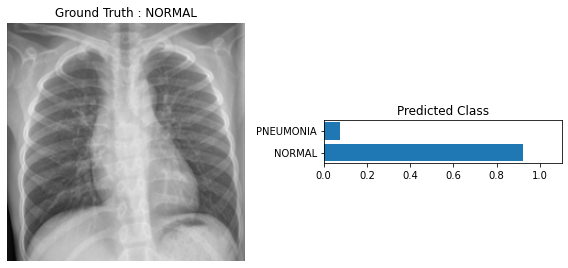

In [23]:
image,label = testset[3]
model = model.to('cpu')
ps = model(image.unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)